# Demo 3: FEDS Near-Real Time (NRT) V.S. WFIGS Current Interagency Fire Perimeters for Quarry Fire on Oct 22, 2023

### Summary

This notebook demonstrates the capabilities of the FEDS-PEC module to function on real time datasets. The FEDS input uses the `public.eis_fire_lf_perimeter_nrt` collection (updated every x ), and compares against the WFIGS Current Interagency Fire Perimeters (updated every 5 minutes). 

Sources for demonstration:
- FEDS near real time perimeters, labeled as `"public.eis_fire_lf_perimeter_nrt"`, source can be viewed here: https://www.earthdata.nasa.gov/dashboard/data-catalog/fire/explore?projection=mercator%7C%7C&basemapid=satellite&datetime=2023-10-22T00%3A00%3A00.000Z&position=-119.8864%7C38.0971%7C9.56
- NIFC WFIGS Current Interagency Fire Perimeters, labeled as `"WFIGS_current_interagency_fire_perimeters"`, source can be viewed here: https://data-nifc.opendata.arcgis.com/datasets/nifc::wfigs-current-interagency-fire-perimeters/explore and the documentation is here: https://nasa-impact.github.io/veda-docs/notebooks/quickstarts/wfs.html


The FEDS input and reference input can use either a pre-defined setting or can accept (valid) user-written paths to shape files. 
- For Input all settings, please see **section INPUT SETTINGS of README.md**  
- Output settings can also be modified to control if calculations are printed, plotted, and/or stored into a file (with location and file type of choice); for more detail on outputs please see **section OUTPUT SETTINGS of README.md**

### Selected Example + Disclaimer

The selected choice for NRT demonstration is the Quarry fire located in the Stanislaus National Forest, with a size of 8,000 acres. As of Oct 22nd 2023 11 AM PDT, the fire is present in both the WFIGS Current Interagency Fire Perimeters and FEDS data set

Disclaimer: users who run this notebook past the current date of Oct 22nd 2023 11 AM PDT may not be able to reproduce results shown here, as the perimeters may no longer exist in the updated datasets. 

#### Motivation 
By enabling NRT capabilities, users interested in the possible operational applications of the FEDS perimeter dataset can explore FEDS performance against official interagency perimeters on an efficient and stream-lined basis.


### Result from Demo for Quarry Fire: Blue (FEDS) VS. NIFC WFIGS Interagency Perimeter (Gold) on Oct 22nd 2022
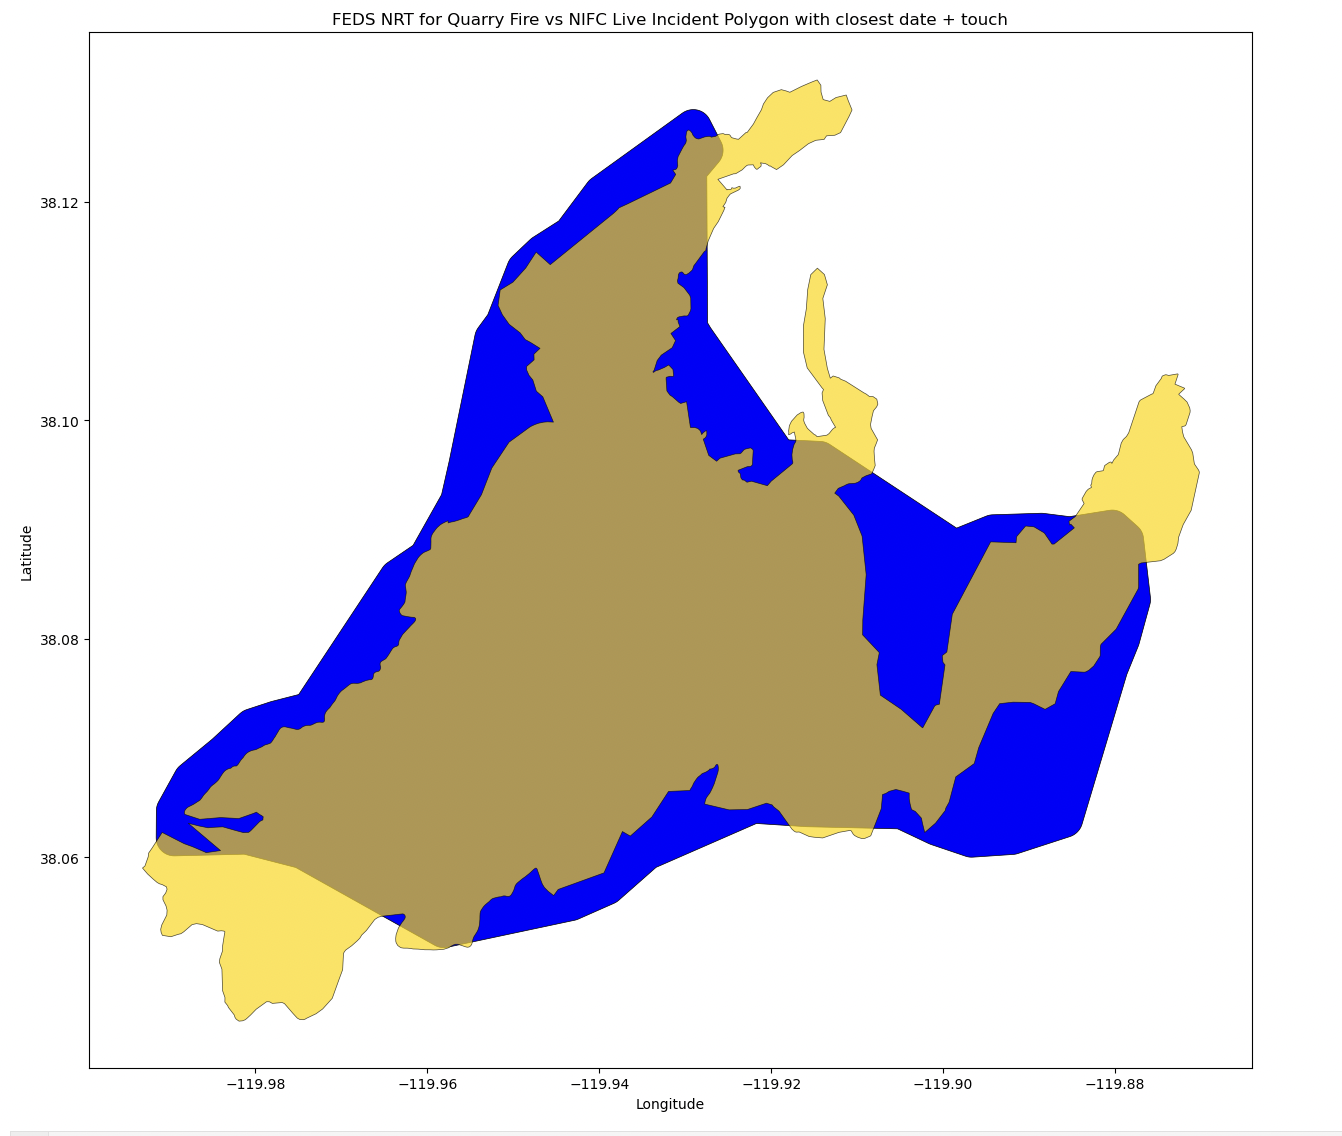



In [11]:
import sys
sys.path.append('/projects/my-public-bucket/VEDA-PEC')

import Utilities
import Input_FEDS
import Input_Reference
import Output_Calculation

from Input_FEDS import InputFEDS
from Input_Reference import InputReference
from Output_Calculation import OutputCalculation
from Utilities import *

In [12]:
# this is the ONLY thing users are intended to modify!
# inputs for searching FEDS and nifc sets

# START TIME
year_start = 2023
month_start = 10
day_start = 10
hour_start = 0
minute_start = 0
second_start = 0
tz_offset_hours_start = 0
tz_offset_minutes_start = 0
utc_offset_start = '00:00'

# END TIME
year_stop = 2023
month_stop = 10
day_stop = 22
hour_stop = 0
minute_stop = 0
second_stop = 0
tz_offset_hours_stop = 0
tz_offset_minutes_stop = 0
utc_offset_stop = '00:00'

# CRS - 4326 RECOMMENDED FEDS FIRE PERIM DEFAULT
crs = 3857 # 4326

# BBOX FOR SEARCH - [lon, lat, lon, lat]
search_bbox = ["-120.17","38.18","-119.67","37.9"]


day_search_range = 7 # acceptable distance to search from feds -> reference (e.g. if refernce polygon is 8 days away, it is not included in calculations)

# FEDS INPUT SETTINGS  # [Change to FEDS Input settings]
feds_title = "firenrt"
feds_collection =  "public.eis_fire_lf_perimeter_nrt"
feds_access_type = "api" # or "local
feds_limit = 1000 # amount of features to consider for FEDS API access; warning appears if it misses any entries
feds_filter = False # False or a valid query: e.g. "farea>5 AND duration>2"
feds_apply_finalfire = True # set this to true if you want the only the latest fireID to be taken per unique FireID

# REFERENCE INPUT SETTINGS 
ref_title = "WFIGS_current_interagency_fire_perimeters" # this is a predefined set example
ref_control_type = "defined" # or "custom"
ref_custom_url = "none" # not custom for demo
ref_custom_read_type = "none"  # not custom for demo
ref_filter = False # False or a valid query

# OUTPUT SETTINGS
maap_username = "ksharonin" # per user, in order to store into user's own public bucket
name_for_output_file = f"firenrt_vs_nifc_interagency_{year_start}_{search_bbox[0]}_{search_bbox[1]}_{search_bbox[2]}_{search_bbox[3]}" # name for your file EXCLUDING PREFIX!
output_format = "txt" # prefix txt, json, others coming
print_on = True # print to jupyter nb
plot_on = False # display plot of comparison

# NOTE: for now don't modify this, just showing you how url is contructed
# [ why would the output need to be maap? Why not just let the user pass a path?]
output_maap_url = f"s3://maap-ops-workspace/shared/{maap_username}/{name_for_output_file}.{output_format}" # maap url to save; MUST BE MAAPS URL! (for now at least to make things simple

### Argument Processing: format and check to report any issues
- Note: upon instance instantiation we can also get reports back of invalidity -> any warnings/errors should be addressed

In [13]:

# start date formatting
search_start = Utilities.format_datetime(year_start, 
                                         month_start, 
                                         day_start, 
                                         hour_start, 
                                         minute_start, 
                                         second_start, 
                                         tz_offset_hours_start, 
                                         tz_offset_minutes_start,
                                         utc_offset_start)
# stop date formatting
search_stop = Utilities.format_datetime(year_stop, 
                                        month_stop, 
                                        day_stop, 
                                        hour_stop, 
                                        minute_stop, 
                                        second_stop, 
                                        tz_offset_hours_stop, 
                                        tz_offset_minutes_stop,
                                        utc_offset_stop)

# bound check the bbox
assert Utilities.check_bbox(search_bbox), f"ERR: passed bbox {search_bbox} is not valid; check bounds"
assert  Utilities.check_crs(crs), f"ERR: invalid crs provided {crs}; please enter valid ESPG CRS number"

### Using Inputs: Instantiate Inputs + Calculation Output

With our inputs, we are ready to start; run this to get the program to fetch the FEDS candidates in the provided time/location window, along with an intersecting NIFC in the specific day range

In this case, we get the latest object of FEDS in the kincade zone + its NIFC closest match, which is about 6 days away and heavily intersecting

In [14]:
# create instances to track properties
print('You may see an ERROR 1 occur; ignore this unless block throws actual exception...')
print('You may see WARNING:fiona.ogrext:Expecting property name enclosed in double quotes: line 1 column 2 (char 1); you can ignore this error safely')

import warnings
warnings.filterwarnings('ignore')
    
feds_firenrt = InputFEDS(
                 feds_title, 
                 feds_collection, 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 feds_access_type,
                 feds_limit,
                 feds_filter,
                 feds_apply_finalfire
                )

nifc_search = InputReference( 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 ref_title,
                 ref_control_type,
                 ref_custom_url,
                 ref_custom_read_type,
                 ref_filter,
                )

my_output = OutputCalculation(
                feds_firenrt,
                nifc_search,
                output_format, 
                output_maap_url,
                day_search_range,
                print_on,
                plot_on
                )

You may see an ERROR 1 occur; ignore this unless block throws actual exception...
You may see WARNING:fiona.ogrext:Expecting property name enclosed in double quotes: line 1 column 2 (char 1); you can ignore this error safely


CALCULATED A RESULT: POLYGON FEDS AT INDEX 23 AGAINST REFERENCE POLYGON AT INDEX 44:
Ratio: 1.178823207718751, Accuracy: 1.4965809650382755, Precision: 0.7241233482764081, Recall: 0.8536134081992377, IOU: 0, F1 0.783554540061081, Symmetric Ratio: 0.47159639132026676
All measurements in units metre


### Print Results with indices

As noted above, this plotting will be moved into the classes. For now, it is demonstrating the same functionality it will have in the future. It uses the returned indices to pick out polygons of interest

In [15]:
feds_nrt_match = feds_firenrt.polygons[feds_firenrt.polygons['index'] == 23] # <-- thats the index match
feds_nrt_match.head()

,geometry,duration,farea,fireid,flinelen,fperim,meanfrp,n_newpixels,n_pixels,ogc_fid,pixden,t,index
23,"POLYGON ((-119.958 38.052, -119.958 38.052, -1...",17.0,41.242803,F121313,3.680011,30.749031,1.531538,39,955,64383,23.155555,2023-10-15T00:00:00,23


In [22]:
nifc_current_match = nifc_search._polygons[nifc_search.polygons['index'] == 44] # <-- thats the index match
nifc_current_match.head()

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_IRWINID,poly_FORID,poly_Acres_AutoCalc,poly_SourceGlobalID,poly_Source,attr_SourceOID,attr_ABCDMisc,attr_ADSPermissionState,attr_CalculatedAcres,attr_ContainmentDateTime,attr_ControlDateTime,attr_CreatedBySystem,attr_IncidentSize,attr_DiscoveryAcres,attr_DispatchCenterID,attr_EstimatedCostToDate,attr_FinalAcres,attr_FFReportApprovedByTitle,attr_FFReportApprovedByUnit,attr_FFReportApprovedDate,attr_FireBehaviorGeneral,attr_FireBehaviorGeneral1,attr_FireBehaviorGeneral2,attr_FireBehaviorGeneral3,attr_FireCause,attr_FireCauseGeneral,attr_FireCauseSpecific,attr_FireCode,attr_FireDepartmentID,attr_FireDiscoveryDateTime,attr_FireMgmtComplexity,attr_FireOutDateTime,attr_FireStrategyConfinePercent,attr_FireStrategyFullSuppPrcnt,attr_FireStrategyMonitorPercent,attr_FireStrategyPointZonePrcnt,attr_FSJobCode,attr_FSOverrideCode,attr_GACC,attr_ICS209ReportDateTime,attr_ICS209RptForTimePeriodFrom,attr_ICS209RptForTimePeriodTo,attr_ICS209ReportStatus,attr_IncidentManagementOrg,attr_IncidentName,attr_IncidentShortDescription,attr_IncidentTypeCategory,attr_IncidentTypeKind,attr_InitialLatitude,attr_InitialLongitude,attr_InitialResponseAcres,attr_InitialResponseDateTime,attr_IrwinID,attr_IsFireCauseInvestigated,attr_IsFireCodeRequested,attr_IsFSAssisted,attr_IsMultiJurisdictional,attr_IsReimbursable,attr_IsTrespass,attr_IsUnifiedCommand,attr_LocalIncidentIdentifier,attr_ModifiedBySystem,attr_PercentContained,attr_PercentPerimToBeContained,attr_POOCity,attr_POOCounty,attr_POODispatchCenterID,attr_POOFips,attr_POOJurisdictionalAgency,attr_POOJurisdictionalUnit,attr_POOJurisdictUnitParentUnit,attr_POOLandownerCategory,attr_POOLandownerKind,attr_POOLegalDescPrincipalMerid,attr_POOLegalDescQtr,attr_POOLegalDescQtrQtr,attr_POOLegalDescRange,attr_POOLegalDescSection,attr_POOLegalDescTownship,attr_POOPredictiveServiceAreaID,attr_POOProtectingAgency,attr_POOProtectingUnit,attr_POOState,attr_PredominantFuelGroup,attr_PredominantFuelModel,attr_PrimaryFuelModel,attr_SecondaryFuelModel,attr_TotalIncidentPersonnel,attr_UniqueFireIdentifier,attr_FORID,attr_WFDSSDecisionStatus,attr_EstimatedFinalCost,attr_OrganizationalAssessment,attr_StratDecisionPublishDate,attr_CreatedOnDateTime_dt,attr_ModifiedOnDateTime_dt,attr_Source,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,Shape__Area,Shape__Length,geometry,DATE_NOT_NONE,DATE_CUR_STAMP,index
44,21213,45841,Quarry,Wildfire Daily Fire Perimeter,Mixed Methods,8645.424382,1696561449000,1697844498000,1.697819e+12,{BCB807DC-5A09-47F2-8C05-F386A6AC803A},None,8645.392857,{BD75E06F-3ED4-4521-8738-3D282859F15D},2023 NIFS,28056169,None,DEFAULT,8645.2887,None,None,wildcade,8080.0,0.01,CASTCC,3128403.0,NaN,None,None,None,Moderate,None,Creeping,Smoldering,Natural,None,None,QN3W,None,1694302320000,Type 3 Incident,None,50.0,0.0,40.0,10.0,P5,0516,OSCC,1.697765e+12,1.697159e+12,1.697762e+12,U,Type 3 IC,QUARRY,Reynolds Creek on Stanislaus NF,WF,FI,38.061,-119.989667,NaN,None,{BCB807DC-5A09-47F2-8C05-F386A6AC803A},None,0,NaN,NaN,NaN,NaN,0.0,001921,wfdss,41.0,73.0,None,Tuolumne,CASTCC,06109,USFS,None,None,USFS,Federal,Mount Diablo,None,None,18E,3.0,2N,SC02,USFS,CASTF,US-CA,None,None,Timber (Litter and Understory),Brush (2 feet),79.0,2023-CASTF-001921,None,Approved Decision,3500000.0,Type 3 Incident,1.696531e+12,1694461146100,1697853285980,IRWIN,0,None,None,{F96D64FA-9275-4B5B-9416-57AB72EF5642},491a5a21-c58b-4f1f-9f2a-c2933b0a303f,0.003593,0.586836,"POLYGON ((-119.90670 38.06589, -119.90677 38.0...",True,2023-10-20 16:30:00,44


### Plot matching polygons

FEDS NRT Polygon Date 23    2023-10-15T00:00:00
Name: t, dtype: object
NIFC WFIGS Polygon Date 44   2023-10-20 16:30:00
Name: DATE_CUR_STAMP, dtype: datetime64[ns]


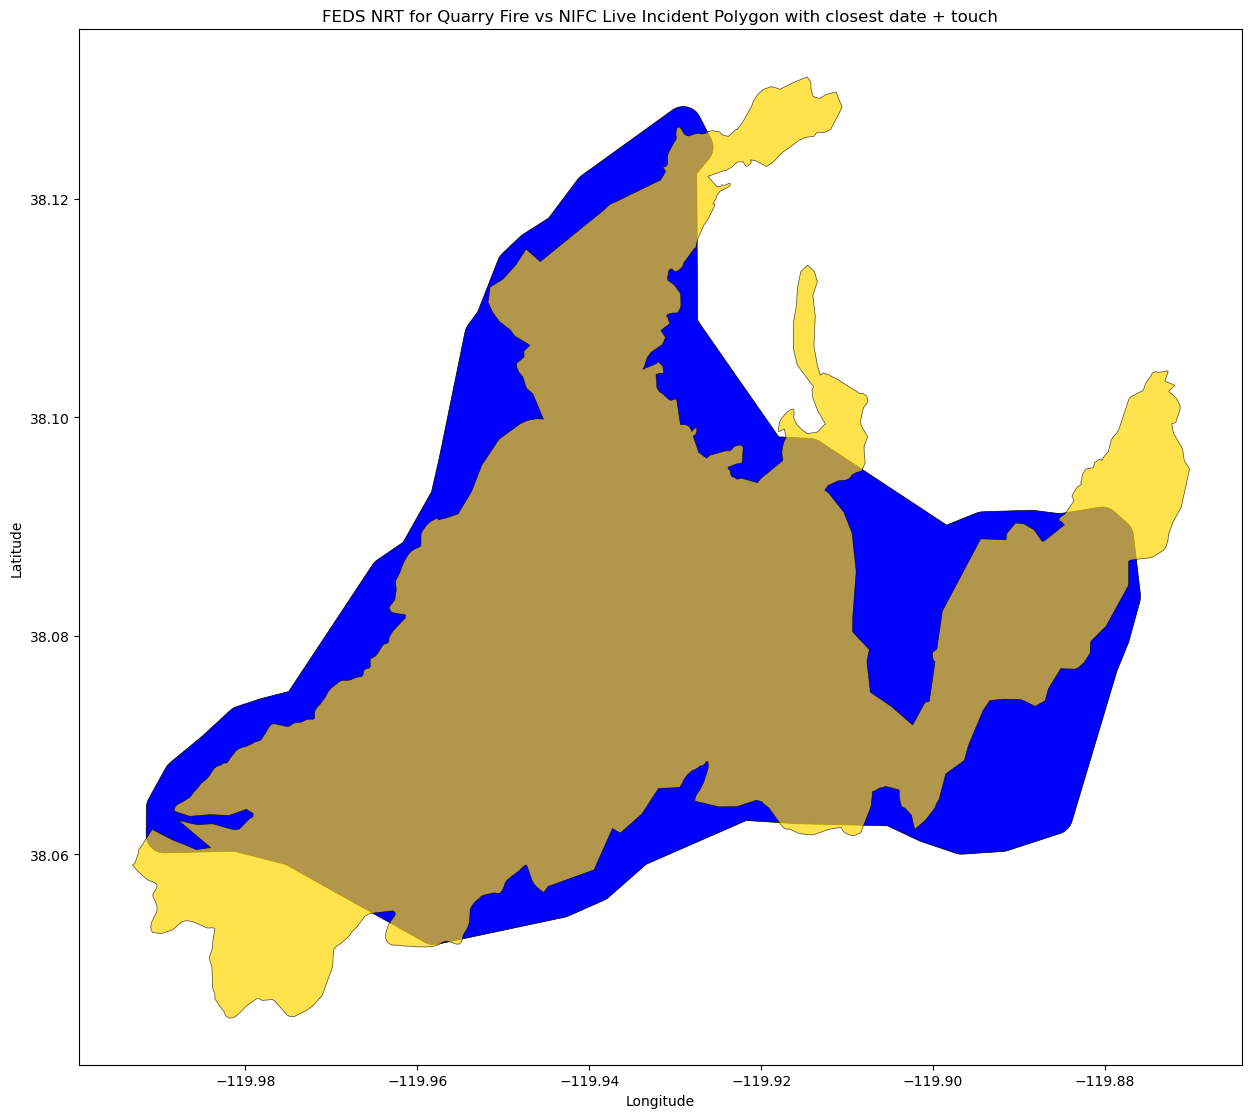

In [23]:
# visualize
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))

print('FEDS NRT Polygon Date', feds_nrt_match['t'])
print('NIFC WFIGS Polygon Date',nifc_current_match['DATE_CUR_STAMP'])


# search_bbox = ["-120.17", "38.18", "-119.67", "37.9"]
# lon_min, lat_max, lon_max, lat_min = map(float, search_bbox)

v = feds_nrt_match.plot(ax=ax, legend=True, label="FEDS NRT MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = nifc_current_match.plot(ax=ax, legend=True, label="WFIGS NIFC NRT", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)

# ax.set_xlim(lon_min, lon_max)
# ax.set_ylim(lat_min, lat_max)
ax.set_title("FEDS NRT for Quarry Fire vs NIFC Live Incident Polygon with closest date + touch")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()
